## Using Py-ART to read and examine data from ARM's X-SAPR2 radar in the Azores 
<center> Scott Collis, Argonne National Laboratory </center>

In [17]:
# first some imports

import pyart # The Python ARM Radar Toolkit
import cartopy.crs as ccrs # A toolkit for map projections
import cartopy.feature as cfeature # A method for adding coastlines etc
import cartopy.io.img_tiles as cimgt # an API into things like google maps
import numpy as np #The famous numpy package!
from matplotlib import pyplot as plt
#Now a Jupyter "Magic" for plotting inline
%matplotlib inline


In [36]:
#Load the data
#you can get the data here:
#https://www.archive.arm.gov/discovery/#v/datastreams/s/streams::enaxsaprsecD1.00/sdate::2018-02-11/edate::2018-02-11
# the following extracts the tar file

! tar -xvf data/enaxsaprsecD1.00.20180211.060011.raw.h5.tar
! cp *.h5 data

x enaxsaprsecD1.00.20180211.060011.raw.sec_XSAPR2_20180211060011_00.h5
x enaxsaprsecD1.00.20180211.060513.raw.sec_XSAPR2_20180211060513_00.h5
x enaxsaprsecD1.00.20180211.061011.raw.sec_XSAPR2_20180211061011_00.h5
x enaxsaprsecD1.00.20180211.061510.raw.sec_XSAPR2_20180211061510_00.h5
x enaxsaprsecD1.00.20180211.062010.raw.sec_XSAPR2_20180211062010_00.h5
x enaxsaprsecD1.00.20180211.062513.raw.sec_XSAPR2_20180211062513_00.h5
x enaxsaprsecD1.00.20180211.063011.raw.sec_XSAPR2_20180211063011_00.h5
x enaxsaprsecD1.00.20180211.063510.raw.sec_XSAPR2_20180211063510_00.h5
x enaxsaprsecD1.00.20180211.064013.raw.sec_XSAPR2_20180211064013_00.h5
x enaxsaprsecD1.00.20180211.064511.raw.sec_XSAPR2_20180211064511_00.h5
x enaxsaprsecD1.00.20180211.065010.raw.sec_XSAPR2_20180211065010_00.h5
x enaxsaprsecD1.00.20180211.065510.raw.sec_XSAPR2_20180211065510_00.h5


In [37]:
radar = pyart.aux_io.read_gamic('enaxsaprsecD1.00.20180211.060011.raw.sec_XSAPR2_20180211060011_00.h5')

In [38]:
#lets see what is in the file
print("The radar has ", radar.ngates, " gates per ray")
print("The radar has ", radar.nrays, " rays per volume")
print("The radar has ", radar.nsweeps, " Sweeps per volume")
for i in range(len(radar.fixed_angle['data'])):
    sweep_start = radar.sweep_start_ray_index['data'][i]
    sweep_end = radar.sweep_start_ray_index['data'][i]
    nrays_in_sweep = sweep_end - sweep_start
    angle = radar.elevation['data'][sweep_start + int(nrays_in_sweep/2.)]
    print("Sweep ", i, " has an elevation of ", angle, ' degrees')




The radar has  1000  gates per ray
The radar has  1936  rays per volume
The radar has  6  Sweeps per volume
Sweep  0  has an elevation of  0.0  degrees
Sweep  1  has an elevation of  0.3955078  degrees
Sweep  2  has an elevation of  0.9008789  degrees
Sweep  3  has an elevation of  1.40625  degrees
Sweep  4  has an elevation of  1.9116212  degrees
Sweep  5  has an elevation of  2.4499514  degrees


In [39]:
#Radar data is in radar.fields
for field in radar.fields.keys():
    print(field, ' has units ', radar.fields[field]['units'])

corrected_reflectivity  has units  dBZ
corrected_velocity  has units  m/s
spectrum_width  has units  m/s
corrected_differential_phase  has units  deg
reflectivity  has units  dBZ
differential_phase  has units  deg
specific_differential_phase  has units  deg/km
cross_correlation_ratio  has units  ratio
normalized_coherent_power  has units  ratio
corrected_differential_reflectivity  has units  dB
differential_reflectivity  has units  dB


### In Py-ART the data is always in data.. lets take a look!

In [40]:
print(radar.fields['reflectivity']['data'])

[[23.689815521240234 39.3668098449707 5.745204925537109 ...
  -6.061615943908691 -10.207186698913574 --]
 [28.01409912109375 40.0318603515625 4.502998352050781 ...
  -8.062623023986816 -8.85951042175293 -10.23062515258789]
 [28.690868377685547 40.53577423095703 -0.3955138623714447 ...
  -10.585122108459473 -- -12.69745922088623]
 ...
 [9.460104942321777 9.72378158569336 -12.1818265914917 ... -- --
  -12.964064598083496]
 [9.038224220275879 7.031357288360596 -13.886930465698242 ... -- -- --]
 [8.921034812927246 8.0098876953125 -8.86244010925293 ...
  -11.513847351074219 -- -11.774593353271484]]


In [41]:
print('The mean reflectivity is ', radar.fields['reflectivity']['data'].mean())

The mean reflectivity is  -12.002457310662365


In [42]:
z_threshold = -8.0

#where command gives you range, ray pairs where a condition is met
#so we take the first element (the time array) and get the lenghth of that 
n_gates_over = np.where(radar.fields['reflectivity']['data'] > z_threshold)[0].shape[0]

#Now take the total gates to get percentage
total_gates = radar.fields['reflectivity']['data'].shape[0] * radar.fields['reflectivity']['data'].shape[1]
percentage_over = 100.0 * n_gates_over/total_gates
print(percentage_over, '% of gates are over ', z_threshold)

21.66038223140496 % of gates are over  -8.0


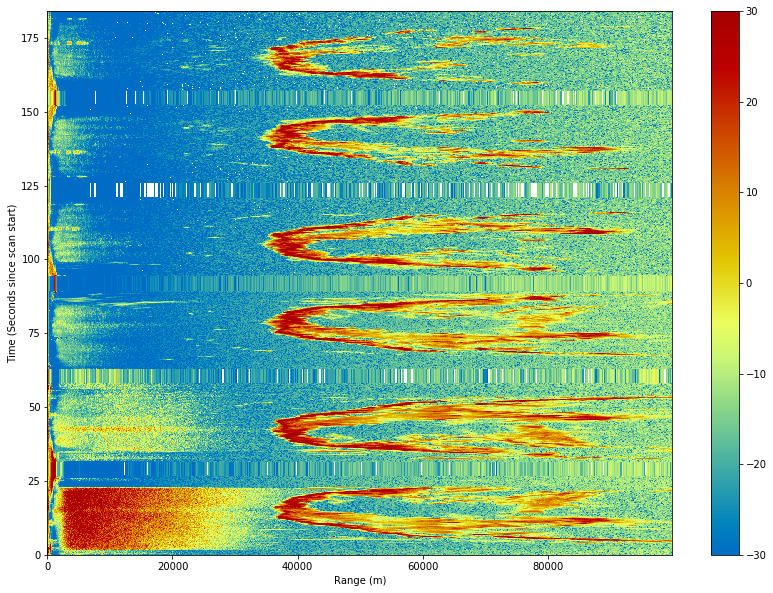

In [49]:
#lets look at the data via a "Bscan"
my_figure = plt.figure(figsize=[14,10]) 
plt.pcolormesh( radar.range['data'], radar.time['data'], radar.fields['reflectivity']['data'],
              cmap = pyart.graph.cm_colorblind.HomeyerRainbow, vmin=-30, vmax = 30)
plt.ylabel('Time (Seconds since scan start)')
plt.xlabel('Range (m)')

plt.colorbar()

In [46]:
#woo!!! Data! Pretty damn ugly though.. Py-ART can help with transforms and plotting

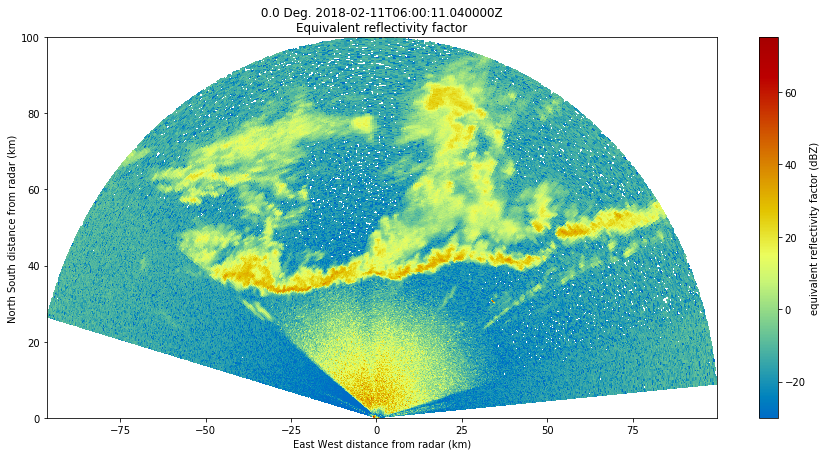

In [55]:
my_figure = plt.figure(figsize=[15,7])
my_radar_display = pyart.graph.RadarDisplay(radar)
my_radar_display.plot_ppi('reflectivity', 0, 
                          cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

min_lat: 39.090954  min_lon: -29.147943  max_lat: 39.989338  max_lon: -26.87222


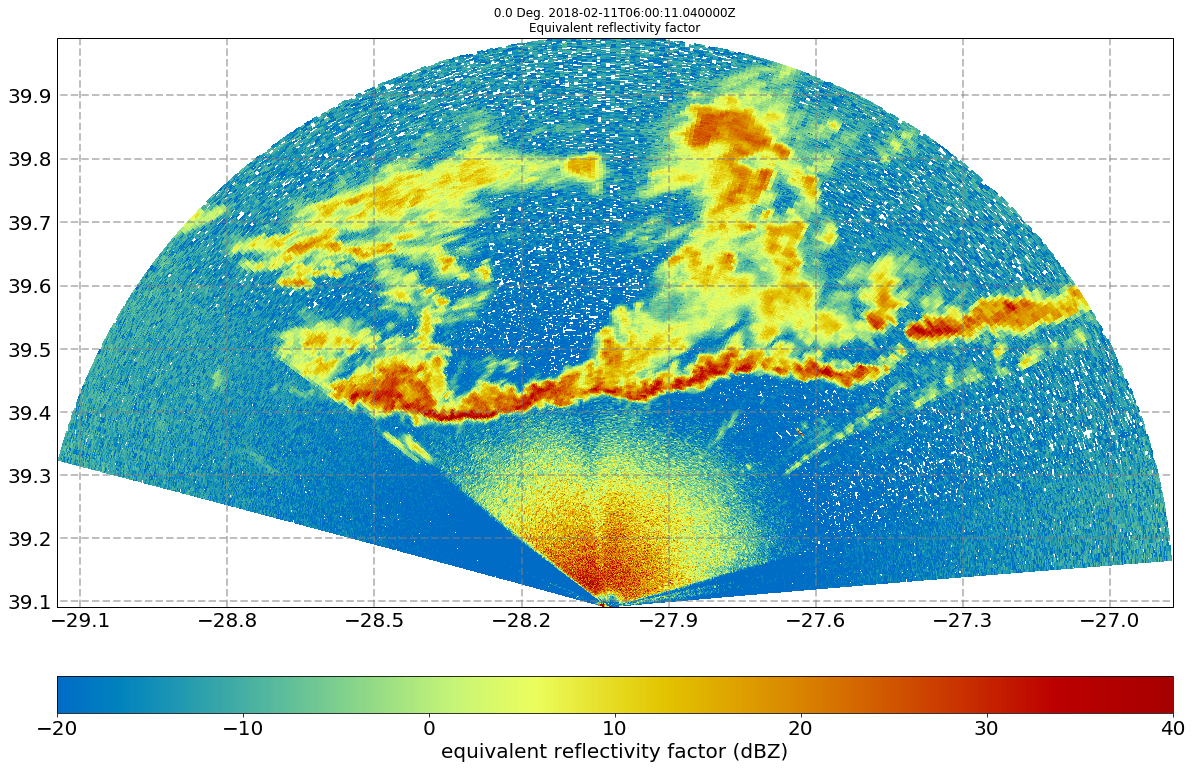

In [100]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data

lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'reflectivity', 0,
    projection=projection, colorbar_flag=False,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-20, vmax=40, cmap=pyart.graph.cm_colorblind.HomeyerRainbow)


#here is our pretty colorbar code
lb = display._get_colorbar_label('reflectivity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False


## So this is all pretty but where is my terrian?

In [115]:
#first.. Lets get rid of some things we do not like

my_gf = pyart.filters.GateFilter(radar)
my_gf.exclude_above('differential_reflectivity', 4)
my_gf.exclude_below('cross_correlation_ratio', .8)
my_ds_gf = pyart.correct.despeckle_field(radar, 'reflectivity', gatefilter=my_gf)

min_lat: 39.090954  min_lon: -29.147943  max_lat: 39.989338  max_lon: -26.87222


/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


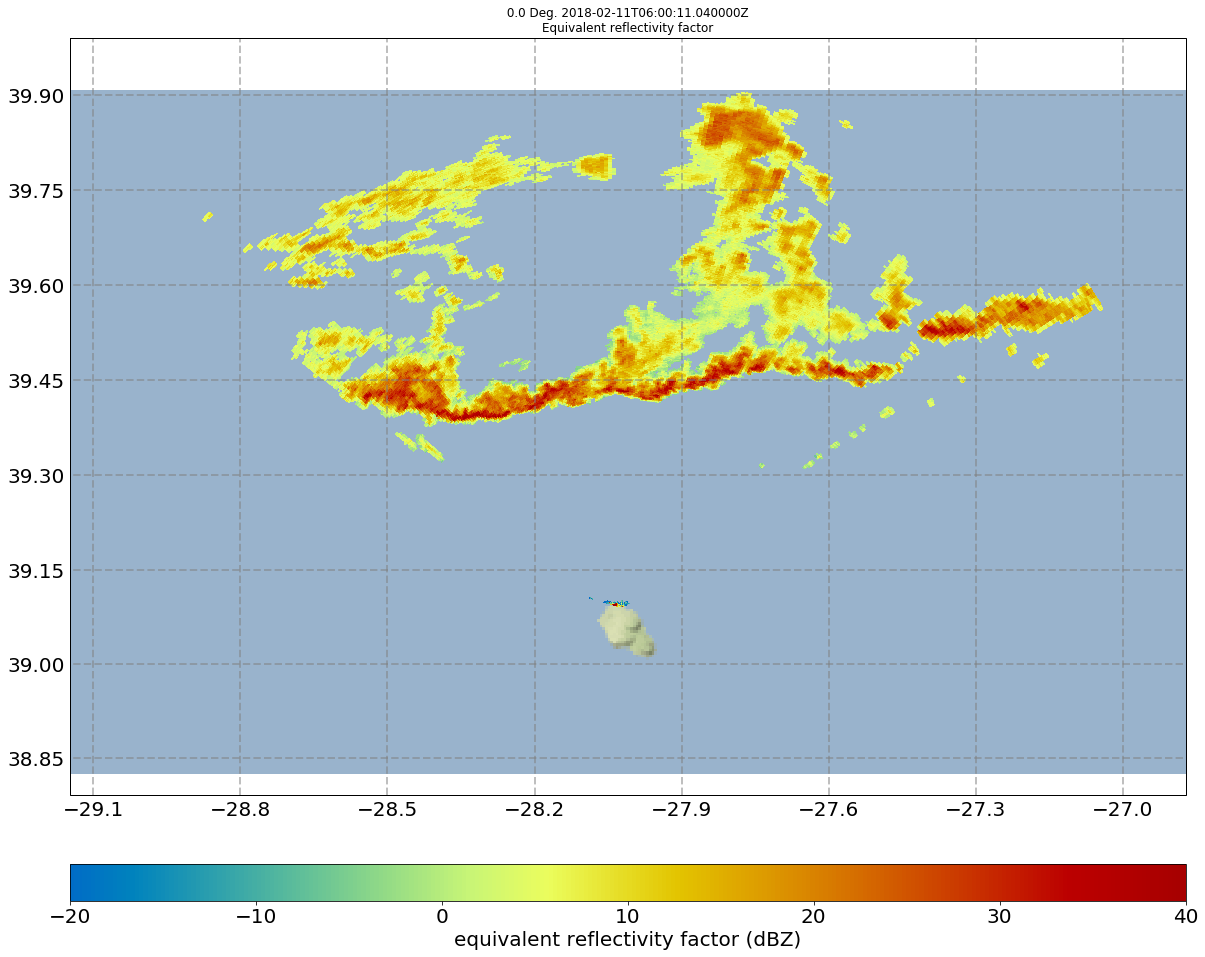

In [133]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data

how_far_south = 0.3

lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat-how_far_south, max_latitude=max_lat)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'reflectivity', 0,
    projection=projection, colorbar_flag=False,
    vmin=-20, vmax=40, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, gatefilter=my_ds_gf)

display.ax.set_extent([min_lon, max_lon, min_lat-how_far_south, max_lat])

#here is our pretty colorbar code
lb = display._get_colorbar_label('reflectivity')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

request = cimgt.StamenTerrain()
display.ax.add_image(request, 8, zorder=0)

    
cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False


In [134]:
#now for someting quantitative.. WARNING.. NEXRAD Z-R dont use for Azores :)
rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500


min_lat: 39.090954  min_lon: -29.147943  max_lat: 39.989338  max_lon: -26.87222


/Users/scollis/anaconda3/envs/pyart-unidata/lib/python3.6/site-packages/cartopy/img_transform.py:76: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  endpoint=False)


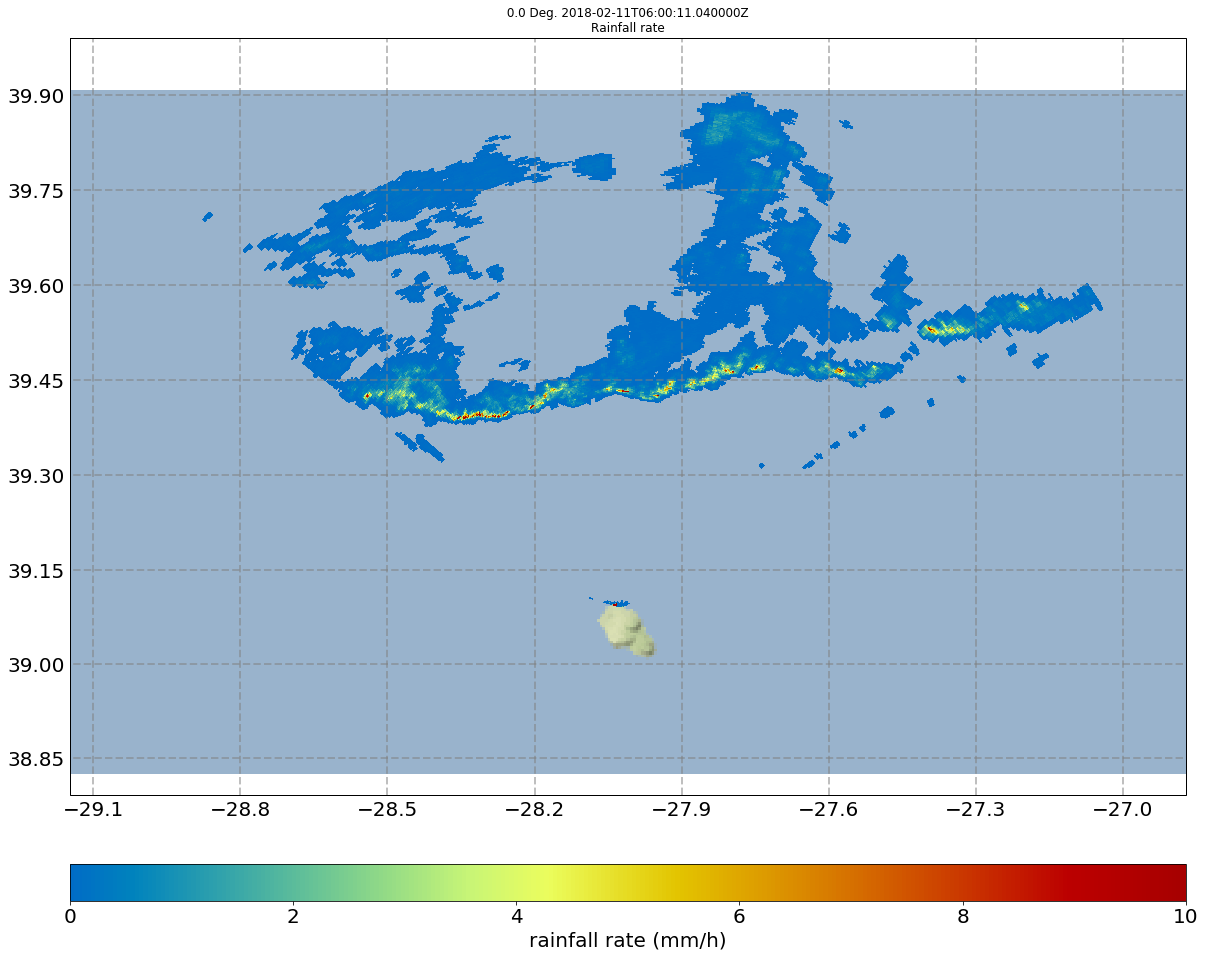

In [136]:
#pretty! but no context!
#lets use the Cartopy package to plot on a map

#I get a bit geeky on this... 

# lets get the extent of the data

how_far_south = 0.3

lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)


#set up the plot
myf = plt.figure(figsize=[20,18])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

# Set up the GIS projection
projection = ccrs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat-how_far_south, max_latitude=max_lat)

#plot a PPI. We specifically ask Py-ART not to add the colorbar... 
#We will customize this to make it nice.

display.plot_ppi_map(
    'rain_z', 0,
    projection=projection, colorbar_flag=False,
    vmin=0, vmax=10, cmap=pyart.graph.cm_colorblind.HomeyerRainbow, gatefilter=my_ds_gf)

display.ax.set_extent([min_lon, max_lon, min_lat-how_far_south, max_lat])

#here is our pretty colorbar code
lb = display._get_colorbar_label('rain_z')
cb = plt.colorbar(display.plots[0], aspect=30, pad=0.07, 
                  orientation='horizontal')

request = cimgt.StamenTerrain()
display.ax.add_image(request, 8, zorder=0)

    
cb.ax.tick_params(labelsize=20)

cb.set_label(lb, fontsize=20)

#Now we add lat lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5,
                          linestyle='--')

gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}

gl.xlabels_top = False
gl.ylabels_right = False
